In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import hp, space_eval
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, SplineTransformer, RobustScaler

from tree_models import run_ada_boost_classifier, run_random_forest_classifier, run_xgboost_classifier, run_xgboost_classifier_search_cv, run_xgboost_classifier_hyperopt
from preprocessing import process_dataset, get_where_all_are_non_null, expand_cabin, expand_passenger_id_to_group, impute_missing_values

sns.set_theme()

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [57]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [90]:
all_data = pd.concat([train_df, test_df], axis=0)

CATEGORICAL_FEATURES = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side", "PassengerGroup"]
NUMERICAL_FEATURES = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNumber"]
ARTIFICIAL_FEATURES = ["TotalMoneySpent", ]

all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)

all_data = all_data.drop(columns=["Name", "Cabin"])

In [91]:
# fill missing categorical values with most common values
all_data["HomePlanet"] = all_data["HomePlanet"].fillna(all_data["HomePlanet"].mode()[0])
all_data["Destination"] = all_data["Destination"].fillna(all_data["Destination"].mode()[0])
all_data["Deck"] = all_data["Deck"].fillna(all_data["Deck"].mode()[0])
all_data["Side"] = all_data["Side"].fillna(all_data["Side"].mode()[0])

all_data["CryoSleep"] = all_data["CryoSleep"].fillna(all_data["CryoSleep"].mode()[0]).astype(np.int32)
all_data["VIP"] = all_data["VIP"].fillna(all_data["VIP"].mode()[0]).astype(np.int32)

# fill missing numerical values with knn imputer
all_data[NUMERICAL_FEATURES] = impute_missing_values(all_data, NUMERICAL_FEATURES, n_neighbors=5)

all_data["CabinNumber"] = all_data["CabinNumber"].astype(np.int32)
all_data["Age"] = all_data["Age"].astype(np.float32)

In [92]:
categorical_encoders = {
    "HomePlanet": LabelEncoder(),
    "Destination": LabelEncoder(),
    "Deck": LabelEncoder(),
    "Side": LabelEncoder()
}

# std_normalizers = {
#     "Age": PowerTransformer(),
#     "RoomService": PowerTransformer(),
#     "FoodCourt": PowerTransformer(),
#     "ShoppingMall": PowerTransformer(),
#     "Spa": PowerTransformer(),
#     "VRDeck": PowerTransformer()
# }
std_normalizers = {
    "Age": RobustScaler(),
    "RoomService": RobustScaler(),
    "FoodCourt": RobustScaler(),
    "ShoppingMall": RobustScaler(),
    "Spa": RobustScaler(),
    "VRDeck": RobustScaler()
}

for cat_encoder_name in categorical_encoders:
    all_data[cat_encoder_name] = categorical_encoders[cat_encoder_name].fit_transform(all_data[cat_encoder_name])

all_data["TotalMoneySpent"] = all_data["RoomService"] + all_data["FoodCourt"] + all_data["ShoppingMall"] + all_data["Spa"] + all_data["VRDeck"]

# for std_normalizers_name in std_normalizers:
#     all_data[std_normalizers_name] = std_normalizers[std_normalizers_name].fit_transform(all_data[std_normalizers_name].to_numpy().reshape(-1, 1))

In [93]:
train_data_df, test_data_df = all_data.loc[~all_data["Transported"].isna()], all_data.loc[all_data["Transported"].isna()]
train_data_df["Transported"] = train_data_df["Transported"].astype(np.int32)

/var/folders/jy/0x3dtb595998ft_1332l_k780000gn/T/ipykernel_1277/3763130414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_df["Transported"] = train_data_df["Transported"].astype(np.int32)


In [120]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ARTIFICIAL_FEATURES) + len(CATEGORICAL_FEATURES)
train_x, train_y = train_data_df[NUMERICAL_FEATURES + ARTIFICIAL_FEATURES + CATEGORICAL_FEATURES], train_data_df["Transported"]

print(f"Total number of features: {total_number_of_features}")

feature_selector = SelectKBest(chi2, k=9)
feature_selector.fit(train_x, train_y)
best_feature_selection = feature_selector.get_feature_names_out()
best_feature_selection

Total number of features: 15


array(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinNumber', 'TotalMoneySpent', 'CryoSleep'], dtype=object)

In [121]:
XGBOOST_CLASSIFIER_HYPEROPT_SPACE = {
    "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 50, dtype=np.int32).tolist()),
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 20, 2, dtype=np.int32).tolist()),
    "max_depth": hp.choice("max_depth", np.arange(3, 20, 2, dtype=np.int32).tolist()),
    "gamma": hp.uniform("gamma", 0.0, 0.9),
    "subsample": hp.uniform("subsample", 0.1, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 0.9),
    "reg_alpha": hp.choice("reg_alpha", [1e-5, 1e-2, 0.1, 1.0, 50, 100])
}

best_params_hyperopt = run_xgboost_classifier_hyperopt(
    train_df=train_data_df,
    feature_columns=best_feature_selection,
    search_space_params=XGBOOST_CLASSIFIER_HYPEROPT_SPACE,
    label_columns=["Transported"],
    shuffle=True,
    number_iterations=200,
    test_size=0.10
)

best_params = space_eval(XGBOOST_CLASSIFIER_HYPEROPT_SPACE, best_params_hyperopt)
print(f"Best parameters: {best_params}")

best_estimator = XGBClassifier(**best_params)

XGBoost Search Space: {'n_estimators': <hyperopt.pyll.base.Apply object at 0x7fd29a648790>, 'min_child_weight': <hyperopt.pyll.base.Apply object at 0x7fd29b79d430>, 'max_depth': <hyperopt.pyll.base.Apply object at 0x7fd29b79deb0>, 'gamma': <hyperopt.pyll.base.Apply object at 0x7fd29b79d2b0>, 'subsample': <hyperopt.pyll.base.Apply object at 0x7fd29b79d850>, 'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x7fd29b79da00>, 'reg_alpha': <hyperopt.pyll.base.Apply object at 0x7fd29b79d370>}
100%|██████████| 200/200 [04:29<00:00,  1.35s/trial, best loss: -0.8310344827586207]
Best parameters: {'colsample_bytree': 0.512405700338466, 'gamma': 0.201411139740009, 'max_depth': 19, 'min_child_weight': 1, 'n_estimators': 650, 'reg_alpha': 50, 'subsample': 0.8286533610347336}


Using features: ['Age' 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck'
 'CabinNumber' 'TotalMoneySpent' 'CryoSleep']


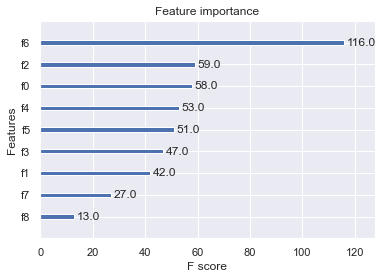

<AxesSubplot:ylabel='rocAuc'>

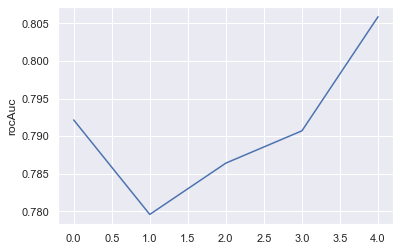

In [122]:
print(f"Using features: {best_feature_selection}")

training_results, predictor = run_xgboost_classifier(
    train_df=train_data_df,
    feature_columns=best_feature_selection,
    label_columns=["Transported"],
    number_of_splits=5,
    shuffle=True,
    xgboost_model_predefined=best_estimator
)

training_df = pd.DataFrame(training_results)

plot_importance(predictor)
plt.show()

sns.lineplot(data=training_df, x=training_df.index, y="rocAuc")

In [123]:
test_predictions = predictor.predict(test_data_df[best_feature_selection].to_numpy())
test_results = pd.concat([test_data_df["PassengerId"], pd.DataFrame(test_predictions, columns=["Transported"])], axis=1)
test_results["Transported"] = test_results["Transported"].astype(bool)
test_results.to_csv("submission.csv", index=False)